In [40]:
import pandas as pd
import numpy as np

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#Surprise 
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

# Importing and Looking at the Data

In [41]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
links = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')

In [42]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [43]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [44]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [45]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [46]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [47]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [48]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [49]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

# EDA

In [50]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [52]:
films = movies.copy()
films.genres = films.genres.str.split('|')
df = explode(films, ['genres'])
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
1,1,Toy Story (1995),Animation
2,1,Toy Story (1995),Children
3,1,Toy Story (1995),Comedy
4,1,Toy Story (1995),Fantasy


Above we have a function that will split the genres into rows

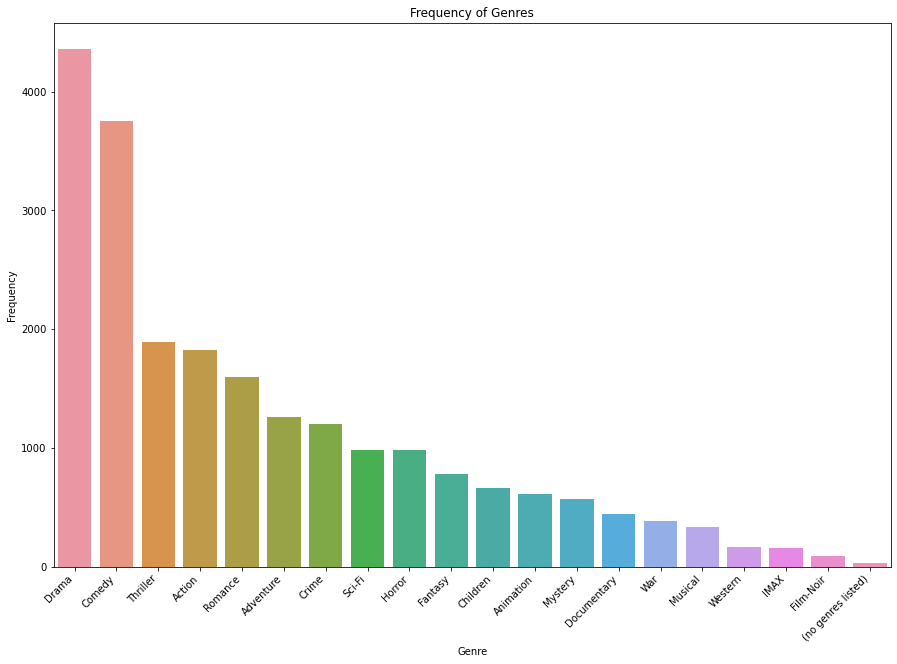

In [19]:
# visualization for frequency of each genre
fig_dims=(15,10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=df.genres.value_counts(), x=df.genres.value_counts().index, ax = ax)
ax.set(xlabel="Genre", ylabel = "Frequency")
ax.set_title("Frequency of Genres")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Here we take the count of the genres and look at their frequency.

In [ ]:
#movies_dummies = movies.join(pd.get_dummies(movies.genres.str.split('|').apply(pd.Series).stack()).sum(level=0))

Above we have a dummies function that we worked out but didn't end up using

In [20]:
import time
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000
1,1,3,4.0,2000
2,1,6,4.0,2000
3,1,47,5.0,2000
4,1,50,5.0,2000


Above we have a conversion of the UTC into the year the review was created

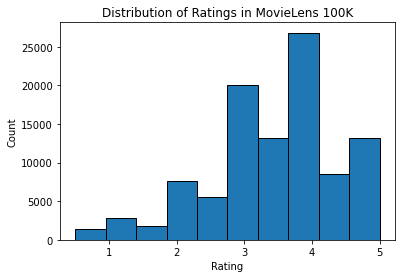

In [21]:
# plotting a histogram of ratings for movies
plt.hist(ratings['rating'], bins=10, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()
# seems like most movies fall in the 3-4 range, not many that have low ratings (1,2)

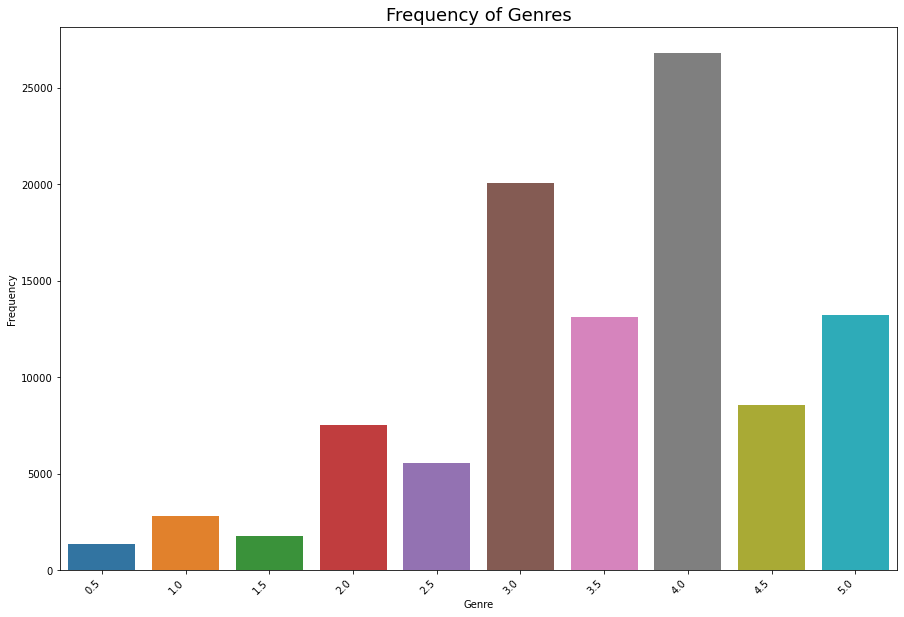

In [23]:
fig_dims=(15,10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=ratings.rating.value_counts(), x=ratings.rating.value_counts().index, ax = ax)
ax.set(xlabel="Genre", ylabel = "Frequency")
ax.set_title("Frequency of Genres", size=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.hlines(data.rating.value_counts().mean(),  -.5 ,9.5 , colors="darkgoldenrod", label="Average Frequency") #plot average price horizontal line\
# plt.legend()
plt.show()

The two visualizations above show the distributions of the ratings.

In [24]:
ratings.drop(columns = 'timestamp', inplace = True)

We drop 'timestamp' since it was preventing us from using Surprise, and it wasn't important

# Setting up our models

In [27]:
# Split into train and test set
reader = Reader()
# Reader ---------------------------------------------------------------------
ratings_surprise = Dataset.load_from_df(ratings,Reader(rating_scale=(0,5)))
# There is only a train set and test set because -----------------------------
trainset, testset = train_test_split(ratings_surprise, test_size=0.2)

#### Basic KNN (Cosine)

In [28]:
sim_cos = {'name':'cosine','user_based':True}
basic_knn = knns.KNNBasic(sim_options=sim_cos)
basic_knn.fit(trainset)
predictions = basic_knn.test(testset)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9766


0.9766134729679561

In the aboved cell, the RMSE represents the distance that any predicted rating is from the acural rating. We want this value to be as small as possible. 0.9765 is okay, but we are really hoping for a smaller number. Let's run more models. Cosine is good here as it is able to handle the sparse dataframe adeptly. 

#### Basic KNN (Pearson)

In [29]:
sim_pearson = {'name':'pearson', 'user_based':True}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765
0.9765350363358744


Here the result isn't as good as the RSME from cosine. The possible reason is that with Pearson there ought to be a rating scale for the users, but in this case they are all weighted equality so the method isn't as effective.

#### KNN Means (Cosine)

In [30]:
knn_means = knns.KNNWithMeans(sim_options=sim_cos)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9057
0.9057283406697952


Here we use KNN Means, with the cosine that we feel is better, and find it improves on the previous models because ...... 

#### KNN Baseline (Cosine)

In [31]:
knn_baseline = knns.KNNBaseline(sim_options=sim_cos)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8838
0.8837917522618216


In [ ]:
With KNN Baseline we get even better results

#### SVD with Grid Search

In [ ]:
# param_grid = {'n_factors':[10, 20, 50],'n_epochs': [10, 15], 'lr_all': [0.005, .0075],
#               'reg_all': [0.01, 0.02, .03, .04, .05, .5, .75, .1]}
# gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
# gs_model.fit(ratings_surprise)

In [ ]:
print(gs_model.best_score)
gs_model.best_params

In [32]:
# matrix factorization
svd = SVD(n_factors=75, n_epochs=15, lr_all=0.02, reg_all=0.07)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8587
0.8587262987995732


Above we use a large set of parameters for the Gridsearch to check for us. We then input them into our SVD model which ...... outputs the best score so far.

In [33]:
user_3_prediction = svd.predict(3, 85)
user_3_prediction

Prediction(uid=3, iid=85, r_ui=None, est=3.231515684100881, details={'was_impossible': False})

Here we input a user id (3) and movie id (85) when we run it through the model we get an estimation of 3.23 which means that user id 3 would rate movie id 85 3.23 out of 5. 

#### Utilizing the model

In [36]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
def ranked_movies(ui):
    list_of_movies = []
    for m_id in movies['movieId'].unique():
        list_of_movies.append( (m_id,svd.predict(ui,m_id)[3]))
# order the predictions from highest to lowest rated
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    return ranked_movies

This function ranks movies for particular individuals, from highest to lowest.

In [37]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
recommended_movies(ranked_movies(6),movies,5)

Recommendation #  1 :  9618    Three Billboards Outside Ebbing, Missouri (2017)
Name: title, dtype: object 

Recommendation #  2 :  314    Forrest Gump (1994)
Name: title, dtype: object 

Recommendation #  3 :  2410    Last Detail, The (1973)
Name: title, dtype: object 

Recommendation #  4 :  2582    Guess Who's Coming to Dinner (1967)
Name: title, dtype: object 

Recommendation #  5 :  3413    Hedwig and the Angry Inch (2000)
Name: title, dtype: object 



this function is taking in the rating a movie and returning the top 5 including the name of the movie